In [7]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [9]:
df = pd.read_csv('data/riceClassification.csv')
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


### Drop id column

In [10]:
df.dropna(inplace=True)
df.drop(['id'], axis=1, inplace=True)

print(df.shape)

(18185, 11)


In [11]:
print(df["Class"].unique())

[1 0]


### Normalize columns

In [12]:
original_df = df.copy()

for column in df.columns:
    df[column] = df[column]/df[column].abs().max()

df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


### Split the dataset

In [13]:
X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, -1])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [15]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [17]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


In [18]:
train_data = dataset(X_train, y_train)
test_data = dataset(X_test, y_test)
validation_data = dataset(X_val, y_val)

In [45]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)

In [46]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = MyModel().to(device)

In [47]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [48]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [49]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(10):
    total_acc_train = 0
    total_acc_val = 0
    total_loss_train = 0
    total_loss_val = 0

    for data in train_dataloader:
        inputs, labels = data

        predictions = model(inputs).squeeze(1)
        batch_loss = criterion(predictions, labels)

        total_loss_train += batch_loss.item()
        acc = ((predictions).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            predictions = model(inputs).squeeze(1)
            batch_loss = criterion(predictions, labels)

            total_loss_val += batch_loss.item()
            acc = ((predictions).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_val_plot.append(round(total_loss_val/1000, 4))

    total_acc_train_plot.append(round(total_acc_train/train_data.__len__()*100, 4))
    total_acc_val_plot.append(round(total_acc_val/validation_data.__len__()*100, 4))
    print(f'Epoch: {epoch+1} Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy {round(total_acc_train/train_data.__len__()*100, 4)}% Validation Accuracy {round(total_acc_val/validation_data.__len__()*100, 4)}')

    print("="*25)



Epoch: 1 Train Loss: 0.2367 Train Accuracy 82.7795% Validation Accuracy 95.2346
Epoch: 2 Train Loss: 0.1315 Train Accuracy 97.5568% Validation Accuracy 97.544
Epoch: 3 Train Loss: 0.0643 Train Accuracy 98.2324% Validation Accuracy 98.0572
Epoch: 4 Train Loss: 0.04 Train Accuracy 98.5388% Validation Accuracy 98.3871
Epoch: 5 Train Loss: 0.03 Train Accuracy 98.5231% Validation Accuracy 98.3504
Epoch: 6 Train Loss: 0.025 Train Accuracy 98.6173% Validation Accuracy 98.0938
Epoch: 7 Train Loss: 0.022 Train Accuracy 98.6095% Validation Accuracy 98.2771
Epoch: 8 Train Loss: 0.0202 Train Accuracy 98.688% Validation Accuracy 98.4604
Epoch: 9 Train Loss: 0.0191 Train Accuracy 98.6095% Validation Accuracy 98.3871
Epoch: 10 Train Loss: 0.0182 Train Accuracy 98.6645% Validation Accuracy 98.717


In [53]:
with torch.no_grad():
    total_acc_test = 0
    total_loss_test = 0

    for data in test_dataloader:
        inputs, labels = data

        predictions = model(inputs).squeeze(1)

        batch_loss_test = criterion(predictions, labels)
        total_loss_test += batch_loss_test

        acc = ((predictions).round() == labels).sum().item()

        total_acc_test += acc

print("Accuracy: {:.3f}%".format(total_acc_test/test_data.__len__()*100))

Accuracy: 98.717%


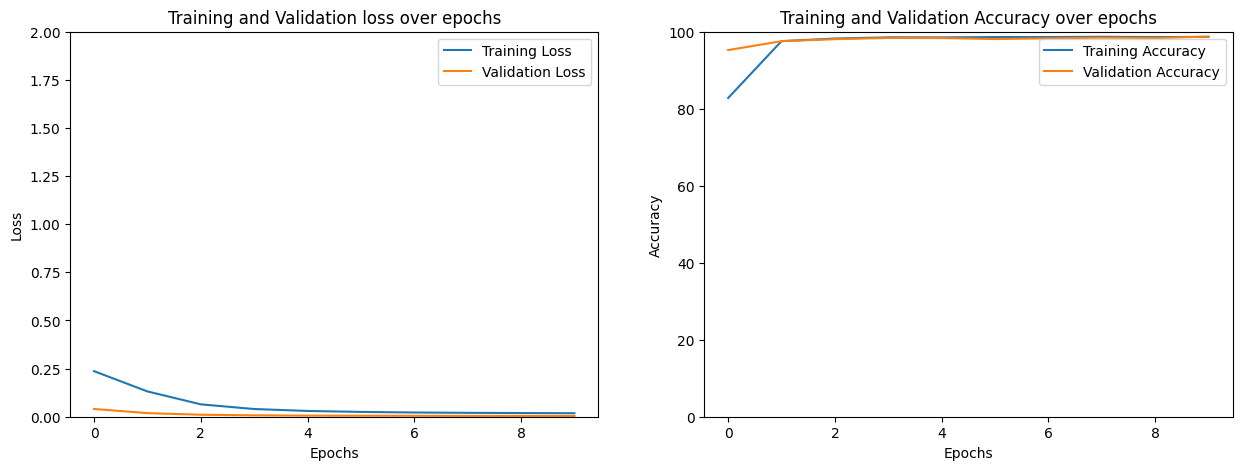

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])
axs[0].legend()


axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [63]:
Area = 2352/original_df['Area'].abs().max()
MajorAxisLength = 81/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = 42/original_df['MinorAxisLength'].abs().max()
Eccentricity = 32/original_df['Eccentricity'].abs().max()
ConvexArea = 12/original_df['ConvexArea'].abs().max()
EquivDiameter = 33/original_df['EquivDiameter'].abs().max()
Extent = 98/original_df['Extent'].abs().max()
Perimeter = 927/original_df['Perimeter'].abs().max()
Roundness = 677/original_df['Roundness'].abs().max()
AspectRation = 24/original_df['AspectRation'].abs().max()

my_prediction = model(torch.tensor([Area, MajorAxisLength, MinorAxisLength, Eccentricity,
       ConvexArea, EquivDiameter, Extent, Perimeter, Roundness,
       AspectRation], dtype=torch.float32).to(device))

In [65]:
print(my_prediction.item())

0.0
